# Legal Text Analysis and Contract Generation

This notebook performs comprehensive analysis of legal documents from the Case_HOLD dataset, including text preprocessing, entity recognition, and contract generation capabilities.

In [ ]:
# Import required libraries
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datasets import load_dataset
import spacy
from wordcloud import WordCloud
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import jinja2
import legal as st
import os
import re
import io
import base64
from PIL import Image

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\manan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load Case_HOLD Dataset

The Case_HOLD (Case Holdings on Legal Decisions) dataset contains legal case text with multiple-choice questions that require selecting the appropriate holding statement.

In [5]:
# Load the Case_HOLD dataset
case_hold = load_dataset("lex_glue", "case_hold")

# Display dataset information
print("Dataset structure:", case_hold)
print("\nAvailable splits:", case_hold.keys())

# Examine a sample
sample = case_hold["train"][1]
print("\nSample entry:")
print(f"Context length: {len(sample['context'])}")
print(f"Endings count: {len(sample['endings'])}")
print(f"Label: {sample['label']}")

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['context', 'endings', 'label'],
        num_rows: 45000
    })
    test: Dataset({
        features: ['context', 'endings', 'label'],
        num_rows: 3600
    })
    validation: Dataset({
        features: ['context', 'endings', 'label'],
        num_rows: 3900
    })
})

Available splits: dict_keys(['train', 'test', 'validation'])

Sample entry:
Context length: 852
Endings count: 5
Label: 1


# 1. Text Preprocessing

Let's perform basic text preprocessing steps on the legal documents:
1. Sentence tokenization
2. Word tokenization
3. Lowercasing
4. Stopword removal
5. Special character handling

In [6]:
def preprocess_text(text):
    """
    Preprocess legal text by performing:
    - Sentence tokenization
    - Word tokenization
    - Lowercasing
    - Stopword removal
    - Special characters handling
    """
    # Sentence tokenization
    sentences = sent_tokenize(text)
    
    # Get English stopwords
    stop_words = set(stopwords.words('english'))
    
    # Process each sentence
    processed_sentences = []
    all_tokens = []
    
    for sentence in sentences:
        # Word tokenization and lowercasing
        tokens = word_tokenize(sentence.lower())
        
        # Remove stopwords and special characters
        filtered_tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
        
        processed_sentences.append(' '.join(filtered_tokens))
        all_tokens.extend(filtered_tokens)
    
    return {
        'original_text': text,
        'sentences': sentences,
        'processed_sentences': processed_sentences,
        'all_tokens': all_tokens,
        'num_sentences': len(sentences),
        'num_tokens': len(all_tokens)
    }

# Get a sample text from the dataset
sample_text = case_hold["train"][1]["context"]

# Preprocess the sample text
preprocessing_results = preprocess_text(sample_text)

# Display the results
print(f"Original text (first 200 chars): {sample_text[:200]}...")
print(f"\nNumber of sentences: {preprocessing_results['num_sentences']}")
print(f"Number of tokens (after preprocessing): {preprocessing_results['num_tokens']}")
print("\nFirst 3 sentences:")
for i, sentence in enumerate(preprocessing_results['sentences'][:3]):
    print(f"Sentence {i+1}: {sentence}")
    
print("\nFirst 3 processed sentences:")
for i, sentence in enumerate(preprocessing_results['processed_sentences'][:3]):
    print(f"Processed Sentence {i+1}: {sentence}")

Original text (first 200 chars): Colameta used customer information that he took from Protégé. Additionally, Colameta admits to having taken at least two Protégé proposals with him to Monument. This type of information may constitute...

Number of sentences: 9
Number of tokens (after preprocessing): 78

First 3 sentences:
Sentence 1: Colameta used customer information that he took from Protégé.
Sentence 2: Additionally, Colameta admits to having taken at least two Protégé proposals with him to Monument.
Sentence 3: This type of information may constitute trade secrets.

First 3 processed sentences:
Processed Sentence 1: colameta used customer information took protégé
Processed Sentence 2: additionally colameta admits taken least two protégé proposals monument
Processed Sentence 3: type information may constitute trade secrets


# 2. Frequency Distribution and Word Count Analysis

Let's analyze word frequencies in the legal text corpus and visualize the distribution of the most common words.

Total unique words: 63

Top 20 most frequent words:
information: 5
trade: 3
secret: 3
colameta: 2
used: 2
protégé: 2
may: 2
see: 2
mass: 2
protection: 2
customer: 1
took: 1
additionally: 1
admits: 1
taken: 1
least: 1
two: 1
proposals: 1
monument: 1
type: 1


C:\Users\manan\AppData\Local\Temp\ipykernel_25880\1478063237.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=freq_analysis['dataframe'].head(20), palette='viridis')


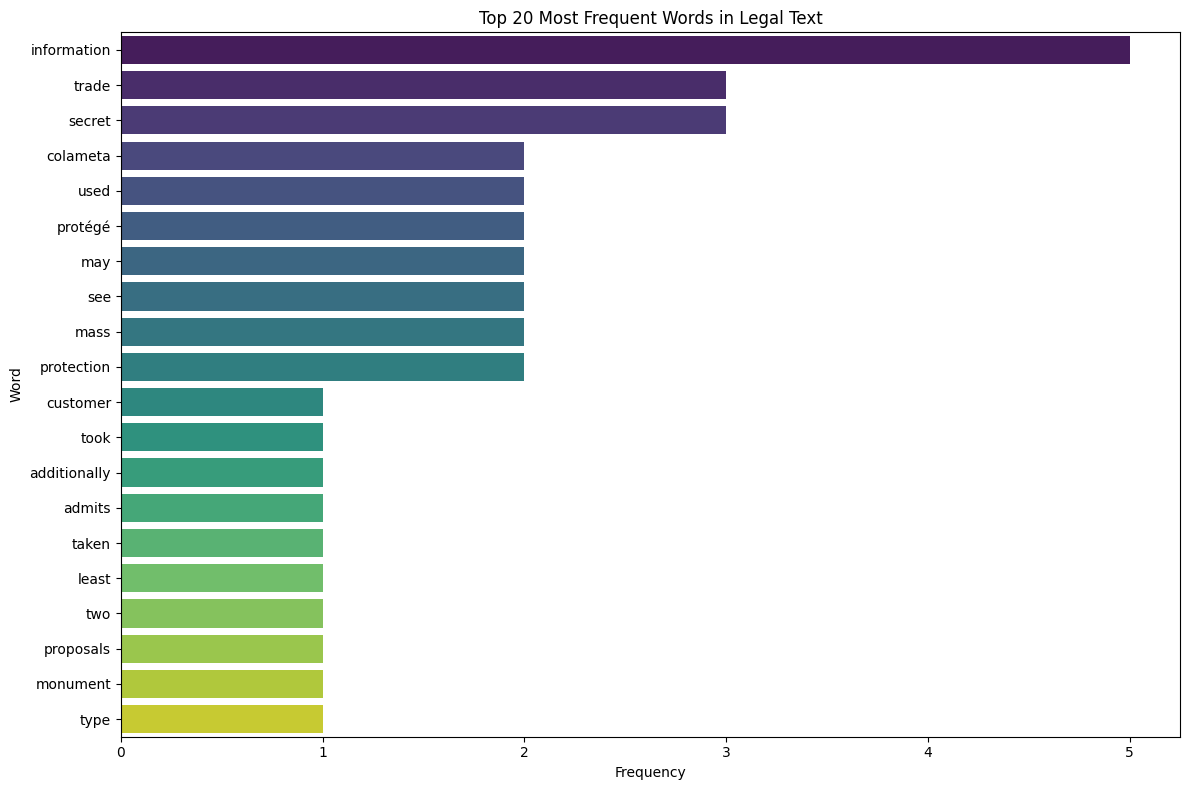

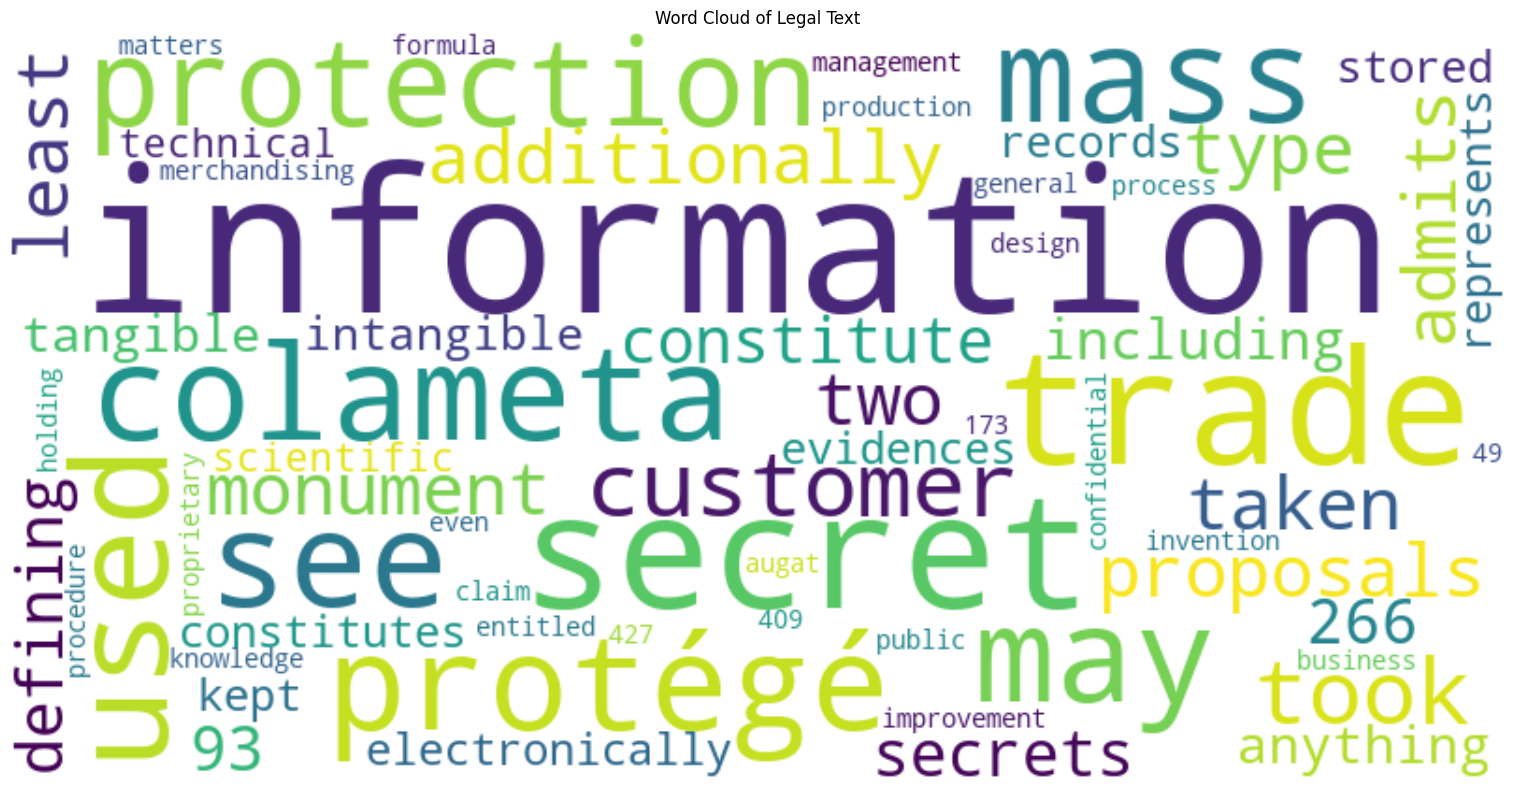

In [7]:
def analyze_word_frequency(tokens, top_n=30):
    """
    Analyze word frequency in a list of tokens
    """
    # Count word frequencies
    word_freq = Counter(tokens)
    
    # Get the top N most common words
    most_common = word_freq.most_common(top_n)
    
    # Create a DataFrame for plotting
    df = pd.DataFrame(most_common, columns=['Word', 'Frequency'])
    
    return {
        'word_freq': word_freq,
        'most_common': most_common,
        'dataframe': df
    }

# Analyze word frequency in the sample text
freq_analysis = analyze_word_frequency(preprocessing_results['all_tokens'])

# Display the results
print(f"Total unique words: {len(freq_analysis['word_freq'])}")
print("\nTop 20 most frequent words:")
for word, freq in freq_analysis['most_common'][:20]:
    print(f"{word}: {freq}")

# Plot the frequency distribution
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=freq_analysis['dataframe'].head(20), palette='viridis')
plt.title('Top 20 Most Frequent Words in Legal Text')
plt.tight_layout()
plt.show()

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(freq_analysis['word_freq'])
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Legal Text')
plt.tight_layout()
plt.show()

# 3. Named Entity Recognition (NER)

We'll apply Named Entity Recognition using spaCy to identify entities in legal texts.

In [8]:
# Load spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
except:
    # If model isn't installed, download it
    print("Downloading spaCy model...")
    !python -m spacy download en_core_web_sm
    nlp = spacy.load('en_core_web_sm')

def perform_ner(text):
    """
    Perform Named Entity Recognition using spaCy
    """
    # Process the text with spaCy
    doc = nlp(text)
    
    # Extract entities
    entities = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    
    return {
        'doc': doc,
        'entities': entities,
        'entity_counts': Counter([ent[3] for ent in entities])
    }

# Perform NER on a sample text (using first 2000 characters to avoid processing too much)
sample_text_shortened = sample_text[:2000]
ner_results = perform_ner(sample_text_shortened)

# Display the first 20 entities found
print("First 20 entities found:")
for i, (text, start, end, label) in enumerate(ner_results['entities'][:20]):
    print(f"{i+1}. {text} ({label})")

# Print entity type counts
print("\nEntity type distribution:")
for entity_type, count in ner_results['entity_counts'].most_common():
    print(f"{entity_type}: {count}")

First 20 entities found:
1. Colameta (ORG)
2. Protégé (GPE)
3. Colameta (ORG)
4. at least two (CARDINAL)
5. Protégé (NORP)
6. 266 (CARDINAL)
7. 93 (CARDINAL)
8. 42 (DATE)
9. Warner-Lambert Co. (ORG)
10. 427 (CARDINAL)
11. Mass. (GPE)
12. 49 (DATE)
13. Augat, Inc. (ORG)
14. 409 (CARDINAL)
15. Mass. (GPE)
16. 173 (CARDINAL)

Entity type distribution:
CARDINAL: 6
ORG: 4
GPE: 3
DATE: 2
NORP: 1


# 4. NER Visualization

Let's visualize the distribution of entity types in the dataset and display entities in text.

C:\Users\manan\AppData\Local\Temp\ipykernel_25880\3017303970.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Entity Type', data=entity_df, palette='viridis')


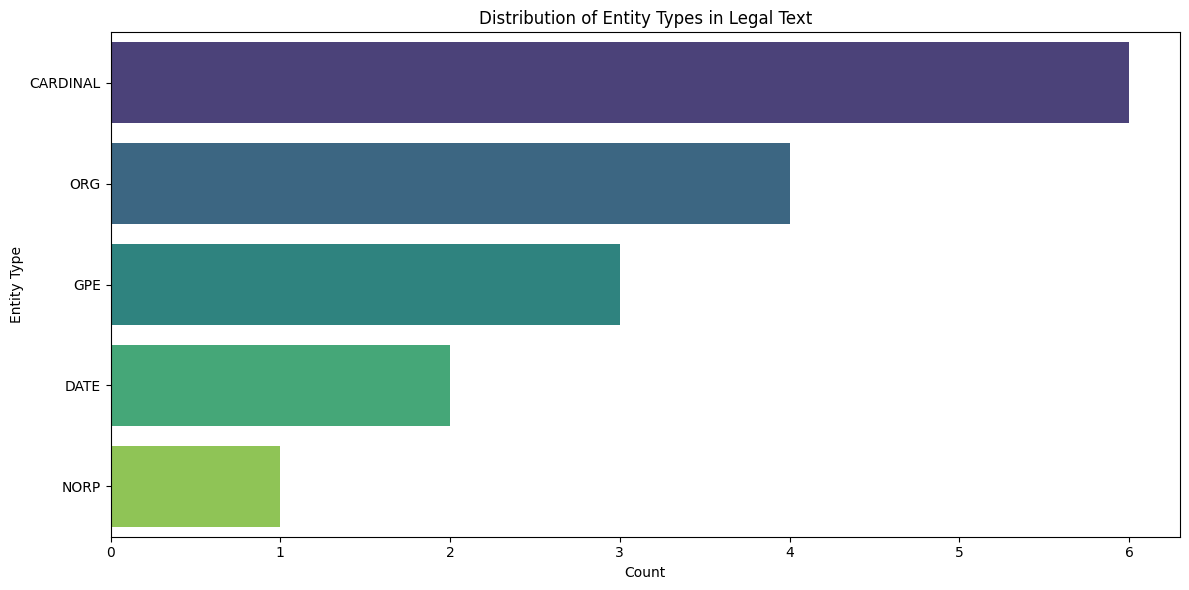


PERSON entities (0):


ORG entities (4):
Augat, Inc., Colameta, Warner-Lambert Co.

GPE entities (3):
Mass., Protégé

LAW entities (0):


DATE entities (2):
42, 49


In [9]:
# Visualize entity distribution
plt.figure(figsize=(12, 6))
entity_df = pd.DataFrame(ner_results['entity_counts'].most_common(), columns=['Entity Type', 'Count'])
sns.barplot(x='Count', y='Entity Type', data=entity_df, palette='viridis')
plt.title('Distribution of Entity Types in Legal Text')
plt.tight_layout()
plt.show()

# Function to visualize entities in text
def visualize_entities_in_text(text, entities, max_length=500):
    """
    Create a visualization showing where entities are in text
    """
    # Truncate text if needed
    if len(text) > max_length:
        text = text[:max_length] + "..."
    
    # Filter entities that are within the displayed text
    visible_entities = [ent for ent in entities if ent[1] < max_length]
    
    # Prepare HTML visualization
    from IPython.display import HTML
    import html
    
    html_text = html.escape(text)
    
    # Replace entities with highlighted spans
    offset = 0
    for ent_text, start, end, label in sorted(visible_entities, key=lambda x: x[1]):
        if start + offset < len(html_text):
            highlight_html = f'<mark style="background-color: #ffffcc; border: 1px solid #e6e600;" title="{label}">{html.escape(ent_text)}</mark>'
            html_text = html_text[:start+offset] + highlight_html + html_text[end+offset:]
            # Adjust offset for the added HTML tags
            offset += len(highlight_html) - (end - start)
    
    html_content = f"""
    <div style="border: 1px solid #ddd; padding: 15px; border-radius: 5px;">
        <h3>Named Entities in Text</h3>
        <p style="line-height: 1.6;">{html_text}</p>
    </div>
    """
    
    return HTML(html_content)

# Visualize entities in the first 500 characters of text
visualize_entities_in_text(sample_text, ner_results['entities'])

# Extract and analyze specific entity types (e.g., PERSON, ORG, LAW)
legal_specific_entities = {
    'PERSON': [],
    'ORG': [],
    'GPE': [],
    'LAW': [],
    'DATE': []
}

for ent_text, start, end, label in ner_results['entities']:
    if label in legal_specific_entities:
        legal_specific_entities[label].append(ent_text)

# Display entities by type
for entity_type, entities in legal_specific_entities.items():
    print(f"\n{entity_type} entities ({len(entities)}):")
    print(', '.join(sorted(set(entities))[:10]))  # Show up to 10 unique entities

# 5. TF-IDF Vectorization

We'll apply TF-IDF vectorization to the legal corpus to analyze feature importance and document similarity.

TF-IDF matrix shape: (10, 62)
Number of features: 62
TF-IDF values for first 5 documents and first 10 features:
       173      266       30      409       42      427       49       93  \
0  0.09245  0.09245  0.09245  0.09245  0.09245  0.09245  0.09245  0.09245   
1  0.09245  0.09245  0.09245  0.09245  0.09245  0.09245  0.09245  0.09245   
2  0.09245  0.09245  0.09245  0.09245  0.09245  0.09245  0.09245  0.09245   
3  0.09245  0.09245  0.09245  0.09245  0.09245  0.09245  0.09245  0.09245   
4  0.09245  0.09245  0.09245  0.09245  0.09245  0.09245  0.09245  0.09245   

   additionally   admits  
0       0.09245  0.09245  
1       0.09245  0.09245  
2       0.09245  0.09245  
3       0.09245  0.09245  
4       0.09245  0.09245  


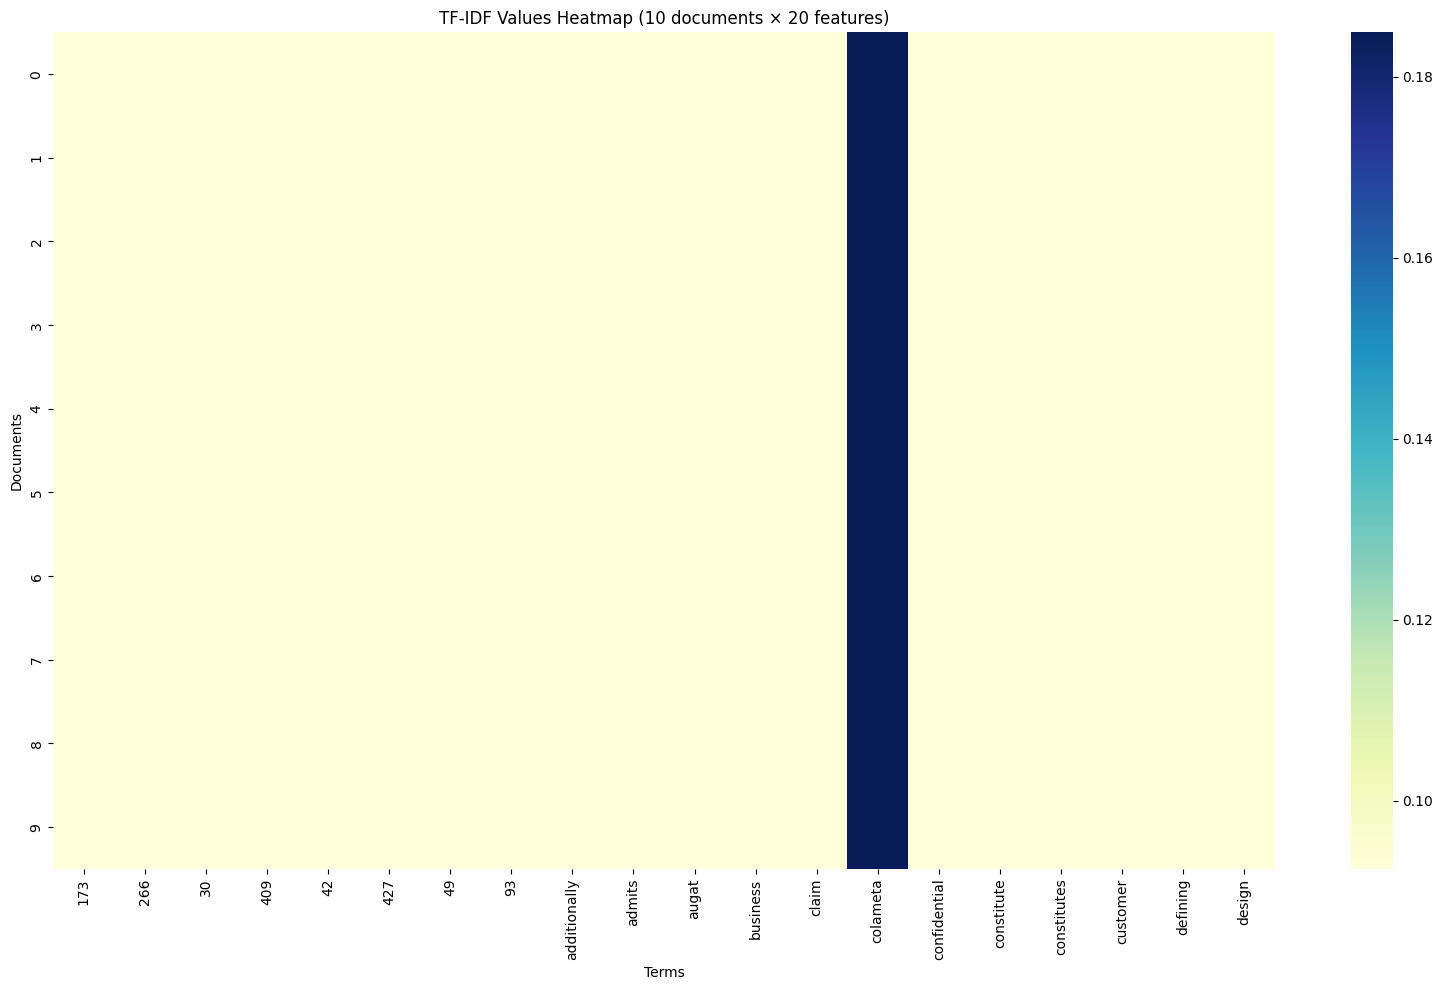


Top 10 terms in the first document:
information: 0.4623
trade: 0.2774
secret: 0.2774
colameta: 0.1849
used: 0.1849
protection: 0.1849
protégé: 0.1849
mass: 0.1849
design: 0.0925
constitutes: 0.0925


In [12]:
def apply_tfidf(documents, max_features=1000):
    """
    Apply TF-IDF vectorization to a corpus of documents
    """
    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
    
    # Fit and transform the documents
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
    
    # Get feature names (words)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    return {
        'vectorizer': tfidf_vectorizer,
        'matrix': tfidf_matrix,
        'feature_names': feature_names
    }

# Get a small sample of documents for demonstration
num_docs = 10
sample_docs = [case_hold["train"][1]["context"] for i in range(num_docs)]

# Apply TF-IDF
tfidf_results = apply_tfidf(sample_docs, max_features=100)

# Convert TF-IDF matrix to DataFrame for visualization
tfidf_df = pd.DataFrame(tfidf_results['matrix'].toarray(), 
                       columns=tfidf_results['feature_names'])

# Show the shape of the TF-IDF matrix
print(f"TF-IDF matrix shape: {tfidf_results['matrix'].shape}")
print(f"Number of features: {len(tfidf_results['feature_names'])}")

# Display first few rows and columns of TF-IDF matrix
print("TF-IDF values for first 5 documents and first 10 features:")
print(tfidf_df.iloc[:5, :10])

# Create a heatmap of TF-IDF values
plt.figure(figsize=(16, 10))
sns.heatmap(tfidf_df.iloc[:10, :20], cmap="YlGnBu", annot=False)
plt.title('TF-IDF Values Heatmap (10 documents × 20 features)')
plt.xlabel('Terms')
plt.ylabel('Documents')
plt.tight_layout()
plt.show()

# Find the most important terms in each document
def get_top_tfidf_terms(tfidf_matrix, feature_names, doc_index, top_n=10):
    """
    Get the top N terms with highest TF-IDF scores for a document
    """
    # Get TF-IDF scores for the document
    doc_tfidf = tfidf_matrix[doc_index].toarray()[0]
    
    # Get indices of top terms
    top_indices = doc_tfidf.argsort()[-top_n:][::-1]
    
    # Get the terms and their scores
    top_terms = [(feature_names[i], doc_tfidf[i]) for i in top_indices]
    
    return top_terms

# Show top terms for the first document
top_terms = get_top_tfidf_terms(tfidf_results['matrix'], tfidf_results['feature_names'], 0)
print("\nTop 10 terms in the first document:")
for term, score in top_terms:
    print(f"{term}: {score:.4f}")

# 6. GloVe Word Embeddings

We'll load pre-trained GloVe embeddings and analyze word similarities in legal contexts.

Loading GloVe embeddings from C:\Users\manan\OneDrive\Desktop\NLP project\glove.6B\glove.6B.100d.txt...
Processed 0 embeddings...
Processed 100000 embeddings...
Loaded 100001 word embeddings.
Collected embeddings for 15 legal terms


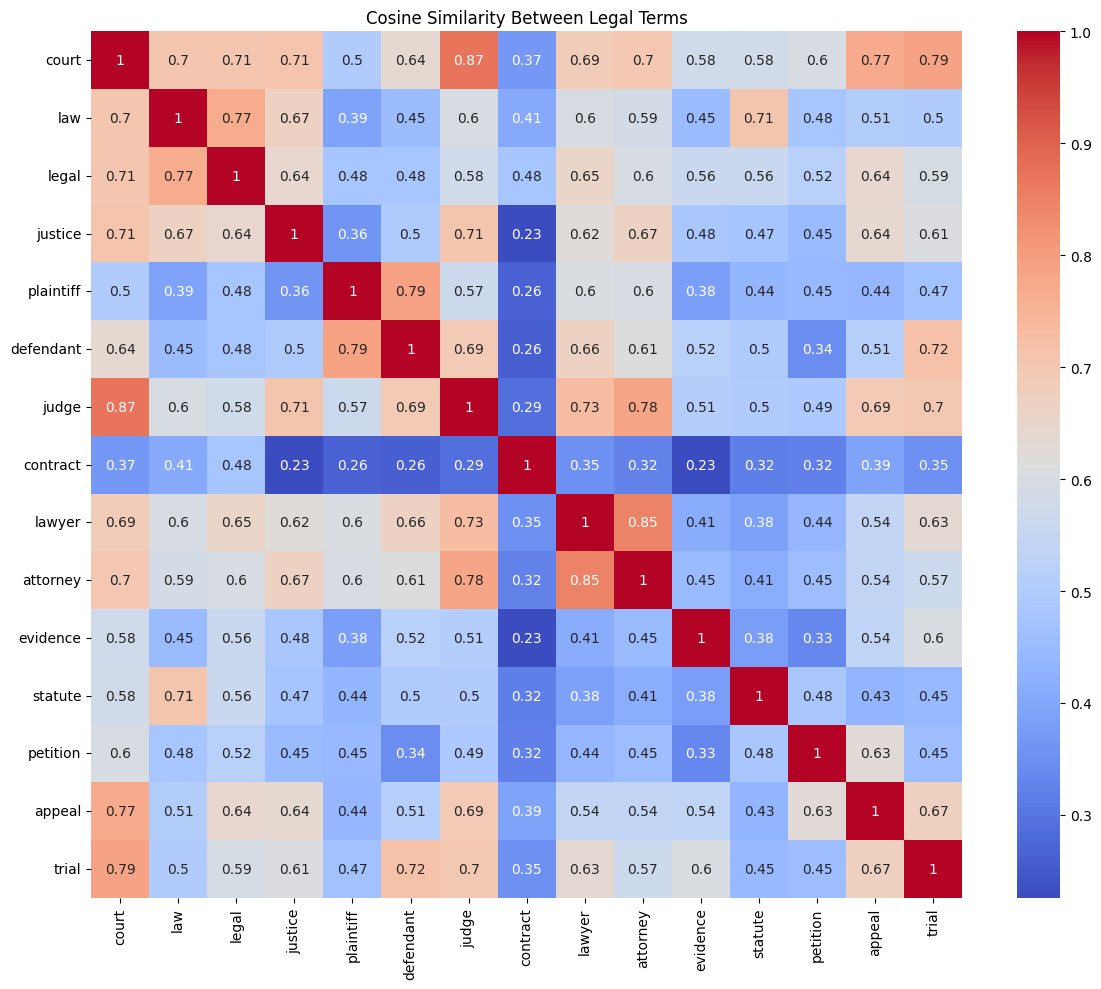

c:\Users\manan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\manan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


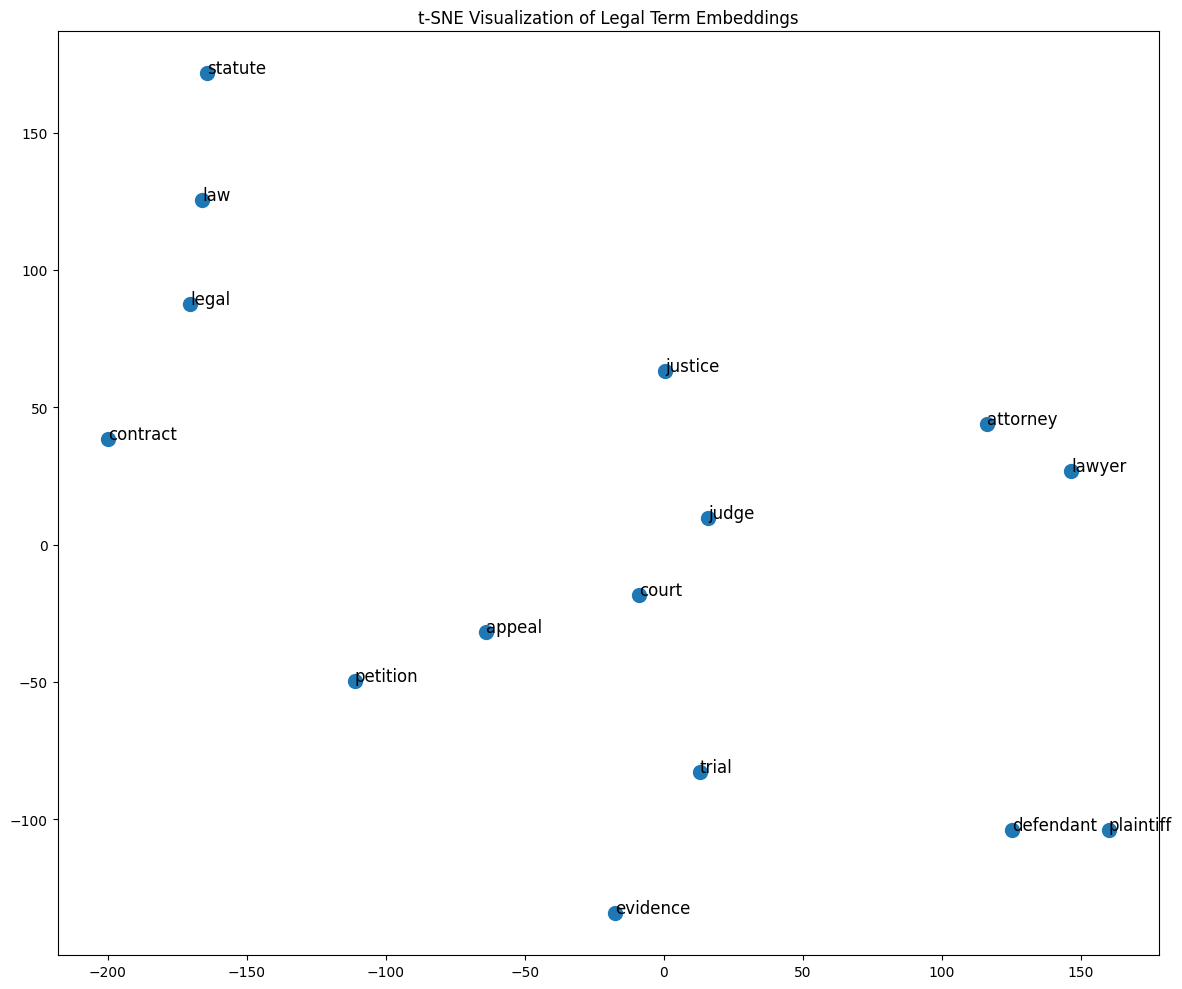

In [9]:
def load_glove_embeddings(path=r"C:\Users\manan\OneDrive\Desktop\NLP project\glove.6B\glove.6B.100d.txt"):
    """
    Load GloVe embeddings from file
    """
    # If file doesn't exist locally, download it
    try:
        import urllib.request
        import os
        
        if not os.path.exists(path):
            print("GloVe embeddings file not found. Downloading a sample version...")
            glove_url = "https://nlp.stanford.edu/data/glove.6B.zip"
            zip_path = "glove.6B.zip"
            
            # Download the zip file
            urllib.request.urlretrieve(glove_url, zip_path)
            
            # Extract the file
            print("Extracting GloVe embeddings...")
            import zipfile
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extract('glove.6B.100d.txt')
            
            # Clean up the zip file
            os.remove(zip_path)
            print("GloVe embeddings downloaded successfully.")
    except Exception as e:
        print(f"Error downloading GloVe embeddings: {e}")
        print("Using a small dummy embedding instead.")
        # Create a small dummy embedding for demonstration
        return {
            'court': np.random.rand(100),
            'law': np.random.rand(100),
            'legal': np.random.rand(100),
            'justice': np.random.rand(100),
            'plaintiff': np.random.rand(100),
            'defendant': np.random.rand(100),
            'judge': np.random.rand(100),
            'contract': np.random.rand(100),
            'lawyer': np.random.rand(100),
            'attorney': np.random.rand(100)
        }
    
    # Load embeddings from file
    print(f"Loading GloVe embeddings from {path}...")
    embeddings = {}
    
    try:
        with open(path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if i % 100000 == 0:
                    print(f"Processed {i} embeddings...")
                
                values = line.strip().split()
                word = values[0]
                vector = np.array(values[1:], dtype='float32')
                embeddings[word] = vector
                
                # For demonstration purposes, limit to 100,000 embeddings
                if i >= 100000:
                    break
    except Exception as e:
        print(f"Error loading embeddings: {e}")
        # Create a small dummy embedding for demonstration
        return {
            'court': np.random.rand(100),
            'law': np.random.rand(100),
            'legal': np.random.rand(100),
            'justice': np.random.rand(100),
            'plaintiff': np.random.rand(100),
            'defendant': np.random.rand(100),
            'judge': np.random.rand(100),
            'contract': np.random.rand(100),
            'lawyer': np.random.rand(100),
            'attorney': np.random.rand(100)
        }
    
    print(f"Loaded {len(embeddings)} word embeddings.")
    return embeddings

# Load GloVe embeddings
glove_embeddings = load_glove_embeddings()

# Define legal terms of interest
legal_terms = [
    'court', 'law', 'legal', 'justice', 'plaintiff',
    'defendant', 'judge', 'contract', 'lawyer', 'attorney',
    'evidence', 'statute', 'petition', 'appeal', 'trial'
]

# Analyze legal term embeddings
legal_term_embeddings = {}
for term in legal_terms:
    if term in glove_embeddings:
        legal_term_embeddings[term] = glove_embeddings[term]
    else:
        print(f"Term '{term}' not found in embeddings")

print(f"Collected embeddings for {len(legal_term_embeddings)} legal terms")

# Compute cosine similarity between terms
def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors"""
    dot = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot / (norm1 * norm2)

# Create similarity matrix
similarity_matrix = np.zeros((len(legal_term_embeddings), len(legal_term_embeddings)))
terms = list(legal_term_embeddings.keys())

for i, term1 in enumerate(terms):
    for j, term2 in enumerate(terms):
        similarity = cosine_similarity(legal_term_embeddings[term1], legal_term_embeddings[term2])
        similarity_matrix[i, j] = similarity

# Visualize similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', xticklabels=terms, yticklabels=terms)
plt.title('Cosine Similarity Between Legal Terms')
plt.tight_layout()
plt.show()

# Visualize word embeddings with t-SNE
if len(legal_term_embeddings) >= 3:  # Need at least 3 terms for meaningful t-SNE
    embeddings_array = np.array(list(legal_term_embeddings.values()))
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(3, len(legal_term_embeddings)-1))
    embeddings_2d = tsne.fit_transform(embeddings_array)

    plt.figure(figsize=(12, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], marker='o', s=100)

    for i, term in enumerate(legal_term_embeddings.keys()):
        plt.annotate(term, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=12)

    plt.title('t-SNE Visualization of Legal Term Embeddings')
    plt.tight_layout()
    plt.show()

# 7. Dynamic Contract Generation with Jinja2

We'll create contract templates with Jinja2 and generate dynamic legal documents based on extracted entities.

In [10]:
def generate_contract(template_text, context):
    """
    Generate a contract using Jinja2 templating
    """
    template = jinja2.Template(template_text)
    rendered_contract = template.render(**context)
    return rendered_contract

# Define a sample contract template
contract_template = """
# LEGAL SERVICES AGREEMENT

THIS LEGAL SERVICES AGREEMENT (the "Agreement") is made and entered into as of {{ date }}, by and between {{ client_name }} ("Client") and {{ law_firm }} ("Law Firm").

## 1. SCOPE OF SERVICES

Law Firm agrees to provide the following legal services to Client (the "Services"):
{% for service in services %}
- {{ service }}
{% endfor %}

## 2. FEES AND PAYMENT

Client agrees to pay Law Firm for the Services at the rate of ${{ hourly_rate }} per hour. Law Firm will bill Client on a monthly basis, and payment is due within {{ payment_term }} days of receipt of each invoice.

## 3. TERM AND TERMINATION

This Agreement shall commence on {{ start_date }} and shall continue until {{ end_date }} or until terminated by either party with {{ termination_notice }} days written notice.

## 4. CONFIDENTIALITY

Law Firm acknowledges that during the engagement, Law Firm will have access to confidential information of Client, which shall be kept strictly confidential.

## 5. GOVERNING LAW

This Agreement shall be governed by and construed in accordance with the laws of the State of {{ governing_state }}.

IN WITNESS WHEREOF, the parties have executed this Agreement as of the date first above written.

CLIENT:                             LAW FIRM:
{{ client_name }}                   {{ law_firm }}

By: ________________________        By: ________________________
Name: {{ client_rep }}              Name: {{ firm_rep }}
Title: {{ client_title }}           Title: {{ firm_title }}
"""

# Use NER results to populate some contract fields
entities_dict = {}
for entity_text, _, _, entity_type in ner_results['entities']:
    if entity_type not in entities_dict:
        entities_dict[entity_type] = []
    entities_dict[entity_type].append(entity_text)

# Create contract context
contract_context = {
    'date': '2023-11-01',
    'client_name': entities_dict.get('ORG', ['ABC Corporation'])[0] if 'ORG' in entities_dict else 'ABC Corporation',
    'law_firm': 'Legal Eagles LLP',
    'services': [
        'Legal representation in the matter of Smith v. Jones',
        'Contract review and negotiation',
        'Legal advice on corporate compliance matters',
        'Preparation of legal memoranda as requested by Client'
    ],
    'hourly_rate': '350',
    'payment_term': '30',
    'start_date': '2023-11-01',
    'end_date': '2024-11-01',
    'termination_notice': '15',
    'governing_state': entities_dict.get('GPE', ['California'])[0] if 'GPE' in entities_dict else 'California',
    'client_rep': entities_dict.get('PERSON', ['John Smith'])[0] if 'PERSON' in entities_dict else 'John Smith',
    'firm_rep': 'Jane Doe',
    'client_title': 'CEO',
    'firm_title': 'Managing Partner'
}

# Generate the contract
generated_contract = generate_contract(contract_template, contract_context)

# Display the generated contract
print("GENERATED CONTRACT:")
print(generated_contract)

# Create a function to save the contract to a file
def save_contract_to_file(contract_text, filename="legal_contract.md"):
    with open(filename, 'w') as f:
        f.write(contract_text)
    print(f"Contract saved to {filename}")

# Uncomment to save the contract to a file
# save_contract_to_file(generated_contract)

GENERATED CONTRACT:

# LEGAL SERVICES AGREEMENT

THIS LEGAL SERVICES AGREEMENT (the "Agreement") is made and entered into as of 2023-11-01, by and between Colameta ("Client") and Legal Eagles LLP ("Law Firm").

## 1. SCOPE OF SERVICES

Law Firm agrees to provide the following legal services to Client (the "Services"):

- Legal representation in the matter of Smith v. Jones

- Contract review and negotiation

- Legal advice on corporate compliance matters

- Preparation of legal memoranda as requested by Client


## 2. FEES AND PAYMENT

Client agrees to pay Law Firm for the Services at the rate of $350 per hour. Law Firm will bill Client on a monthly basis, and payment is due within 30 days of receipt of each invoice.

## 3. TERM AND TERMINATION

This Agreement shall commence on 2023-11-01 and shall continue until 2024-11-01 or until terminated by either party with 15 days written notice.

## 4. CONFIDENTIALITY

Law Firm acknowledges that during the engagement, Law Firm will have access

# 8. Streamlit UI Deployment

Let's develop a Streamlit interface for interactive legal text analysis and contract generation.

In [ ]:
# Define the Streamlit app code (this won't run in the notebook, but can be saved to a separate file)
streamlit_code = '''
import streamlit as st
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from wordcloud import WordCloud
from collections import Counter
import numpy as np
import jinja2
import base64
from io import BytesIO

# Download necessary NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Load spaCy model
@st.cache_resource
def load_spacy_model():
    return spacy.load('en_core_web_sm')

nlp = load_spacy_model()

# Page configuration
st.set_page_config(page_title="Legal Text Analyzer", layout="wide")

# Sidebar
st.sidebar.title("Legal Text Analysis")
page = st.sidebar.selectbox(
    "Choose a feature",
    ["Text Analysis", "Named Entity Recognition", "Contract Generator"]
)

# Contract template
contract_template = """
# LEGAL SERVICES AGREEMENT

THIS LEGAL SERVICES AGREEMENT (the "Agreement") is made and entered into as of {{ date }}, by and between {{ client_name }} ("Client") and {{ law_firm }} ("Law Firm").

## 1. SCOPE OF SERVICES

Law Firm agrees to provide the following legal services to Client (the "Services"):
{% for service in services %}
- {{ service }}
{% endfor %}

## 2. FEES AND PAYMENT

Client agrees to pay Law Firm for the Services at the rate of ${{ hourly_rate }} per hour. Law Firm will bill Client on a monthly basis, and payment is due within {{ payment_term }} days of receipt of each invoice.

## 3. TERM AND TERMINATION

This Agreement shall commence on {{ start_date }} and shall continue until {{ end_date }} or until terminated by either party with {{ termination_notice }} days written notice.

## 4. CONFIDENTIALITY

Law Firm acknowledges that during the engagement, Law Firm will have access to confidential information of Client, which shall be kept strictly confidential.

## 5. GOVERNING LAW

This Agreement shall be governed by and construed in accordance with the laws of the State of {{ governing_state }}.

IN WITNESS WHEREOF, the parties have executed this Agreement as of the date first above written.

CLIENT:                             LAW FIRM:
{{ client_name }}                   {{ law_firm }}

By: ________________________        By: ________________________
Name: {{ client_rep }}              Name: {{ firm_rep }}
Title: {{ client_title }}           Title: {{ firm_title }}
"""

# Define functions
def preprocess_text(text):
    sentences = sent_tokenize(text)
    stop_words = set(stopwords.words('english'))
    
    processed_sentences = []
    all_tokens = []
    
    for sentence in sentences:
        tokens = word_tokenize(sentence.lower())
        filtered_tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
        
        processed_sentences.append(' '.join(filtered_tokens))
        all_tokens.extend(filtered_tokens)
    
    return {
        'original_text': text,
        'sentences': sentences,
        'processed_sentences': processed_sentences,
        'all_tokens': all_tokens,
        'num_sentences': len(sentences),
        'num_tokens': len(all_tokens)
    }

def analyze_word_frequency(tokens, top_n=30):
    word_freq = Counter(tokens)
    most_common = word_freq.most_common(top_n)
    df = pd.DataFrame(most_common, columns=['Word', 'Frequency'])
    return {'word_freq': word_freq, 'dataframe': df}

def generate_wordcloud(word_freq):
    wc = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(word_freq)
    return wc

def perform_ner(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    entity_counts = Counter([ent[1] for ent in entities])
    return {'entities': entities, 'entity_counts': entity_counts}

def get_wordcloud_img(wordcloud):
    img = BytesIO()
    wordcloud.to_image().save(img, format='PNG')
    return img

def generate_contract(template_text, context):
    template = jinja2.Template(template_text)
    rendered_contract = template.render(**context)
    return rendered_contract

def create_download_link(content, filename, text):
    b64 = base64.b64encode(content.encode()).decode()
    href = f'<a href="data:file/txt;base64,{b64}" download="{filename}">{text}</a>'
    return href

# Main area - Text Analysis Page
if page == "Text Analysis":
    st.title("Legal Text Analysis")
    
    # Text input
    text_input = st.text_area("Enter legal text for analysis", height=200)
    
    if text_input:
        # Preprocess text
        preprocessing_results = preprocess_text(text_input)
        
        # Display basic stats
        col1, col2 = st.columns(2)
        with col1:
            st.write(f"Number of sentences: {preprocessing_results['num_sentences']}")
        with col2:
            st.write(f"Number of tokens (after preprocessing): {preprocessing_results['num_tokens']}")
        
        # Word frequency analysis
        freq_analysis = analyze_word_frequency(preprocessing_results['all_tokens'])
        
        # Word frequency table
        st.subheader("Top Words")
        st.dataframe(freq_analysis['dataframe'].head(20), use_container_width=True)
        
        # Word frequency chart
        st.subheader("Word Frequency Distribution")
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x='Frequency', y='Word', data=freq_analysis['dataframe'].head(15), palette='viridis', ax=ax)
        st.pyplot(fig)
        
        # Word cloud
        st.subheader("Word Cloud")
        wordcloud = generate_wordcloud(freq_analysis['word_freq'])
        st.image(wordcloud.to_array(), use_column_width=True)

# Named Entity Recognition Page
elif page == "Named Entity Recognition":
    st.title("Named Entity Recognition")
    
    # Text input
    text_input = st.text_area("Enter legal text for entity extraction", height=200)
    
    if text_input:
        # Process with spaCy for NER
        with st.spinner("Performing Named Entity Recognition..."):
            ner_results = perform_ner(text_input)
        
        # Display entities table
        st.subheader("Entities Found")
        entities_df = pd.DataFrame(ner_results['entities'], columns=['Entity', 'Type'])
        st.dataframe(entities_df, use_container_width=True)
        
        # Entity type distribution
        st.subheader("Entity Type Distribution")
        entity_counts_df = pd.DataFrame(list(ner_results['entity_counts'].items()), 
                                        columns=['Entity Type', 'Count'])
        entity_counts_df = entity_counts_df.sort_values('Count', ascending=False)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x='Count', y='Entity Type', data=entity_counts_df, palette='viridis', ax=ax)
        st.pyplot(fig)
        
        # Entity extraction by type
        st.subheader("Extracted Entities by Type")
        selected_type = st.selectbox("Select entity type", options=sorted(entity_counts_df['Entity Type'].tolist()))
        
        if selected_type:
            filtered_entities = [entity for entity, entity_type in ner_results['entities'] if entity_type == selected_type]
            unique_entities = sorted(set(filtered_entities))
            
            if unique_entities:
                st.write(f"{len(unique_entities)} unique {selected_type} entities found:")
                st.write(", ".join(unique_entities))
            else:
                st.write(f"No entities of type {selected_type} found.")

# Contract Generator Page
elif page == "Contract Generator":
    st.title("Legal Contract Generator")
    
    # Contract form
    st.subheader("Contract Information")
    
    col1, col2 = st.columns(2)
    
    with col1:
        date = st.date_input("Agreement Date")
        client_name = st.text_input("Client Name", "ABC Corporation")
        law_firm = st.text_input("Law Firm", "Legal Eagles LLP")
        hourly_rate = st.number_input("Hourly Rate ($)", min_value=0, value=350)
        payment_term = st.number_input("Payment Term (days)", min_value=1, value=30)
    
    with col2:
        start_date = st.date_input("Start Date")
        end_date = st.date_input("End Date")
        termination_notice = st.number_input("Termination Notice (days)", min_value=1, value=15)
        governing_state = st.text_input("Governing State", "California")
    
    st.subheader("Representatives")
    col1, col2 = st.columns(2)
    
    with col1:
        client_rep = st.text_input("Client Representative", "John Smith")
        client_title = st.text_input("Client Title", "CEO")
    
    with col2:
        firm_rep = st.text_input("Firm Representative", "Jane Doe")
        firm_title = st.text_input("Firm Title", "Managing Partner")
    
    st.subheader("Services")
    services = []
    for i in range(4):
        service = st.text_input(f"Service {i+1}", value="" if i > 0 else "Legal representation")
        if service:
            services.append(service)
    
    # Generate contract
    if st.button("Generate Contract"):
        contract_context = {
            'date': date.strftime("%Y-%m-%d"),
            'client_name': client_name,
            'law_firm': law_firm,
            'services': services,
            'hourly_rate': str(hourly_rate),
            'payment_term': str(payment_term),
            'start_date': start_date.strftime("%Y-%m-%d"),
            'end_date': end_date.strftime("%Y-%m-%d"),
            'termination_notice': str(termination_notice),
            'governing_state': governing_state,
            'client_rep': client_rep,
            'firm_rep': firm_rep,
            'client_title': client_title,
            'firm_title': firm_title
        }
        
        generated_contract = generate_contract(contract_template, contract_context)
        
        st.subheader("Generated Contract")
        st.markdown(generated_contract)
        
        # Download link
        st.markdown(
            create_download_link(
                generated_contract, 
                f"legal_contract_{date.strftime('%Y-%m-%d')}.md", 
                "Download Contract as Markdown"
            ),
            unsafe_allow_html=True
        )
'''

# Display the Streamlit code with a message on how to run it
print("To use the Streamlit interface, save the following code to a file named 'legal_text_analyzer.py' and run with: streamlit run legal_text_analyzer.py")
print("\n" + "-" * 80 + "\n")
print(streamlit_code)

# Create a function to save the Streamlit code to a file
def save_streamlit_code(code, filename="legal_text_analyzer.py"):
    with open(filename, 'w') as f:
        f.write(code)
    print(f"\nStreamlit code saved to {filename}")
    print(f"To run the app, use the command: streamlit run {filename}")

# Uncomment to save the Streamlit code
# save_streamlit_code(streamlit_code)

# Conclusion

This notebook has demonstrated a comprehensive workflow for legal text analysis, including:

1. Text preprocessing of legal documents
2. Word frequency analysis and visualization 
3. Named Entity Recognition (NER) and visualization for legal texts
4. TF-IDF vectorization for feature importance analysis
5. Use of GloVe word embeddings to analyze semantic relationships in legal terminology
6. Contract generation using Jinja2 templates
7. Interactive UI development with Streamlit

These tools and techniques can be applied to various legal analytics tasks, including contract analysis, case law research, and legal document generation.